# Requirements

In [5]:
import torch
import torch_geometric

In [6]:
import torch
import torch_geometric
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.dropout import dropout_adj
from torch_geometric.nn import DenseGCNConv

# Data

In [8]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

# Functions

In [10]:
def to_sparse(edge_ind):
  return torch.sparse_coo_tensor(edge_ind, torch.ones_like(edge_ind[0])).to_dense()

def to_index(sparse):
  res = sparse.float().nonzero().permute(1,0)
  return res

def mirror(sparse):
  upper = torch.triu(sparse)
  lower = torch.rot90(torch.flip(torch.triu(sparse, diagonal=1), [0]), 3, [0,1])
  return upper + lower

def set_diagonal(sparse, target=0):
  copy = sparse.clone()
  return copy.fill_diagonal_(target)

def make_symmetric(sparse):
  res = mirror(sparse)
  # res = set_diagonal(res)
  return res

def invert_by(sparse, flip_dense):
  return (sparse + flip_dense) - torch.mul(sparse * flip_dense, 2)


# Model

In [11]:
class GCN_Dense(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = DenseGCNConv(dataset.num_node_features, 64)
        self.conv2 = DenseGCNConv(64, dataset.num_classes)

    def forward(self, x, dense):
        # x, edge_index = data.x, data.edge_index

        x = self.conv1(x, dense)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, dense)

        return F.log_softmax(x, dim=1)

# Train a model regularly

In [12]:
def denseTrain(model_dense, data, optimizer, epochs, hide_res = False):
  model_dense.train()
  res = []
  for epoch in range(epochs):
    optimizer.zero_grad()

    pred = model_dense(data.x, to_sparse(data.edge_index)).squeeze()

    train_correct = (pred.squeeze().argmax(1)[data.train_mask] == data.y[data.train_mask]).sum()
    train_acc = int(train_correct) / int(data.train_mask.sum())

    test_correct = (pred.squeeze().argmax(1)[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = int(test_correct) / int(data.test_mask.sum())

    loss = F.cross_entropy(pred[data.train_mask], data.y[data.train_mask])
    if not hide_res:
      print(f"Epoch: {epoch + 1} \t (C) Train: {train_acc*100:<.1f}% \t (C) Test: {test_acc*100:<.1f}% \t Train Loss: {loss:<.2f}")
    
    loss.backward()
    optimizer.step()

    res.append([epoch, train_acc, test_acc, loss.item() / 2])

  return res

def denseTrainVersusReal(model_dense, data_altered, data_real, optimizer, epochs):
  model_dense.train()
  res = []

  for epoch in range(epochs):
    optimizer.zero_grad()

    pred = model_dense(data_altered.x, to_sparse(data_altered.edge_index)).squeeze()

    train_correct = (pred.squeeze().argmax(1)[data_altered.train_mask] == data_altered.y[data_altered.train_mask]).sum()
    train_acc = int(train_correct) / int(data_altered.train_mask.sum())

    real_pred = model_dense(data_real.x, to_sparse(data_real.edge_index)).squeeze()

    test_correct = (real_pred.squeeze().argmax(1)[data_real.test_mask] == data_real.y[data_real.test_mask]).sum()
    test_acc = int(test_correct) / int(data_real.test_mask.sum())

    loss = F.cross_entropy(pred[data_altered.train_mask], data_altered.y[data_altered.train_mask])
    print(f"Epoch: {epoch + 1} \t (A) Train: {train_acc*100:<.1f}% \t (C) Test: {test_acc*100:<.1f}% \t Train Loss: {loss:<.2f}")
    
    loss.backward()
    optimizer.step()

    res.append([epoch, train_acc, test_acc, loss.item() / 2])

  return res

In [13]:
def showGraph(res, style=""):
  n = np.array(res)
  df = pd.DataFrame(data=n, columns=["Epoch", "train_acc", "test_acc", "train_loss"])
  sns.lineplot(data=pd.melt(df, ['Epoch']), x='Epoch', y='value', hue='variable', linestyle=style)

In [14]:
model_dense = GCN_Dense().to(device)
optimizer = torch.optim.Adam(model_dense.parameters(), lr=0.01, weight_decay=5e-4)
denseTrain(model_dense, data, optimizer, 10)

Epoch: 1 	 (C) Train: 15.7% 	 (C) Test: 15.3% 	 Train Loss: 1.94
Epoch: 2 	 (C) Train: 85.7% 	 (C) Test: 56.2% 	 Train Loss: 1.69
Epoch: 3 	 (C) Train: 93.6% 	 (C) Test: 66.7% 	 Train Loss: 1.39
Epoch: 4 	 (C) Train: 92.9% 	 (C) Test: 69.6% 	 Train Loss: 1.09
Epoch: 5 	 (C) Train: 95.0% 	 (C) Test: 71.3% 	 Train Loss: 0.81
Epoch: 6 	 (C) Train: 97.1% 	 (C) Test: 75.1% 	 Train Loss: 0.61
Epoch: 7 	 (C) Train: 96.4% 	 (C) Test: 74.6% 	 Train Loss: 0.46
Epoch: 8 	 (C) Train: 95.7% 	 (C) Test: 77.2% 	 Train Loss: 0.34
Epoch: 9 	 (C) Train: 97.1% 	 (C) Test: 76.2% 	 Train Loss: 0.24
Epoch: 10 	 (C) Train: 97.9% 	 (C) Test: 77.2% 	 Train Loss: 0.18


[[0, 0.15714285714285714, 0.153, 0.9701910018920898],
 [1, 0.8571428571428571, 0.562, 0.8442350029945374],
 [2, 0.9357142857142857, 0.667, 0.697474479675293],
 [3, 0.9285714285714286, 0.696, 0.5433295965194702],
 [4, 0.95, 0.713, 0.4060267210006714],
 [5, 0.9714285714285714, 0.751, 0.3025546967983246],
 [6, 0.9642857142857143, 0.746, 0.2279176563024521],
 [7, 0.9571428571428572, 0.772, 0.17018283903598785],
 [8, 0.9714285714285714, 0.762, 0.1221892237663269],
 [9, 0.9785714285714285, 0.772, 0.0895456075668335]]

# Implementation from Topology paper: https://arxiv.org/pdf/1906.04214.pdf

In [15]:
def min_min_attack(model, data, epsilon=5, attack_epochs=5):

  edges = to_sparse(data.edge_index).float() # Create adjacency matrix
  edges.requires_grad = True

  pred = model(data.x, edges).squeeze() # Initial prediction from clean data
  
  for epoch in range(attack_epochs):

    loss = - F.cross_entropy(pred[data.train_mask], data.y[data.train_mask]) # Calculate loss of prediction on clean data
    loss.backward()

    grad = edges.grad.detach()
    grad = grad * (1/grad.max()) # Scale the gradient maximum to 1
    grad = (grad * epsilon).clamp(0,1) # Amplify by epsilon, Keep only range (0,1)

    min_loss = 1000 # Initialize min loss

    for k in range(3):
      sample = torch.bernoulli(grad) # Draw bernoulli samples from the gradient of adj. matrix

      sample = make_symmetric(sample) # Repair the sample so that it is symmetric about the diagonal

      perturbed_data = invert_by(edges, sample) # Invert the adjacency matrix by the sample drawn

      attack_pred = model(data.x, perturbed_data).squeeze() # Get the loss of the new perturbed data
      loss = F.cross_entropy(attack_pred[data.train_mask], data.y[data.train_mask])

      if loss < min_loss: # Check to see if the loss is lower than before
        min_loss = loss
        min_loss_data = perturbed_data
        edges_altered = sample.sum()

    print(f"Attack Epoch: {epoch+1}/{attack_epochs} \t Best sample loss: {min_loss:<.3f} \t Edges altered: {sample.sum():<.0f}/{2708 ** 2}")

    pred = model(data.x, min_loss_data).squeeze() # Redo prediction to get lower loss

  return min_loss_data

print("REGULAR MODEL =========================") # Train a regular model
model_dense = GCN_Dense().to(device)
optimizer = torch.optim.Adam(model_dense.parameters(), lr=0.01, weight_decay=5e-4)
reg = denseTrain(model_dense, data, optimizer, 30)

print("ATTACK THE DATA =======================") # Attack the data

model_dense = GCN_Dense().to(device) # Train a surrogate model
optimizer = torch.optim.Adam(model_dense.parameters(), lr=0.01, weight_decay=5e-4)
denseTrain(model_dense, data, optimizer, 5, hide_res = True)

perturbed_edges = min_min_attack(model_dense, data) # Use the surrogate model to create a perturbed dataset
perturbed_data = data.clone()
perturbed_data.edge_index = to_index(perturbed_edges)

print("TRAIN MODEL ON ATTACKED DATA ==========") # Train a model on the perturbed dataset
attacked_model = GCN_Dense().to(device)
optimizer = torch.optim.Adam(attacked_model.parameters(), lr=0.01, weight_decay=5e-4) # (C) is Clean, (A) is Attacked
atk = denseTrainVersusReal(attacked_model, perturbed_data, data, optimizer, 30)

REGULAR MODEL =========================
Epoch: 1 	 (C) Train: 5.0% 	 (C) Test: 13.8% 	 Train Loss: 1.97
Epoch: 2 	 (C) Train: 87.9% 	 (C) Test: 60.3% 	 Train Loss: 1.74
Epoch: 3 	 (C) Train: 92.9% 	 (C) Test: 68.4% 	 Train Loss: 1.48
Epoch: 4 	 (C) Train: 97.1% 	 (C) Test: 72.6% 	 Train Loss: 1.17
Epoch: 5 	 (C) Train: 97.9% 	 (C) Test: 72.4% 	 Train Loss: 0.91
Epoch: 6 	 (C) Train: 98.6% 	 (C) Test: 72.6% 	 Train Loss: 0.69
Epoch: 7 	 (C) Train: 95.7% 	 (C) Test: 73.7% 	 Train Loss: 0.53
Epoch: 8 	 (C) Train: 97.9% 	 (C) Test: 72.1% 	 Train Loss: 0.38
Epoch: 9 	 (C) Train: 98.6% 	 (C) Test: 73.1% 	 Train Loss: 0.31
Epoch: 10 	 (C) Train: 96.4% 	 (C) Test: 71.1% 	 Train Loss: 0.23
Epoch: 11 	 (C) Train: 97.9% 	 (C) Test: 72.5% 	 Train Loss: 0.19
Epoch: 12 	 (C) Train: 97.9% 	 (C) Test: 72.7% 	 Train Loss: 0.15
Epoch: 13 	 (C) Train: 99.3% 	 (C) Test: 74.1% 	 Train Loss: 0.11
Epoch: 14 	 (C) Train: 99.3% 	 (C) Test: 76.4% 	 Train Loss: 0.07
Epoch: 15 	 (C) Train: 100.0% 	 (C) Test: 75.7

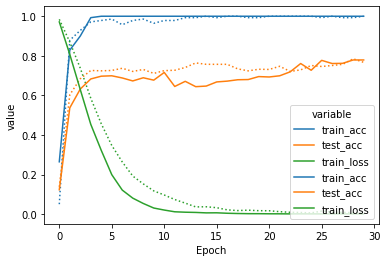

In [16]:
showGraph(reg, "dotted") # Regular model results are dotted
showGraph(atk, "-")

# Greedy implementation (NOT WORKING YET!!!)

In [17]:
def greedy_min_min_attack(model, data, epsilon=100000, attack_epochs=10):

  edges = to_sparse(data.edge_index).float() # Create adjacency matrix
  edges.requires_grad = True

  pred = model(data.x, edges).squeeze() # Initial prediction from clean data
  
  for epoch in range(attack_epochs):

    loss = - F.cross_entropy(pred[data.train_mask], data.y[data.train_mask]) # Calculate loss of prediction on clean data
    loss.backward()

    grad = edges.grad.detach()

    min_loss = 1000 # Initialize min loss

    for k in range(3):

      v, i = torch.topk(grad.flatten(), epsilon)
      indices = np.array(np.unravel_index(i.numpy(), grad.shape)).T

      # sample = to_sparse(torch.tensor(indices))

      # print(sample.shape, indices[0])

      sample = make_symmetric(sample) # Repair the sample so that it is symmetric about the diagonal

      perturbed_data = invert_by(edges, sample) # Invert the adjacency matrix by the sample drawn

      attack_pred = model(data.x, perturbed_data).squeeze() # Get the loss of the new perturbed data
      loss = F.cross_entropy(attack_pred[data.train_mask], data.y[data.train_mask])

      if loss < min_loss: # Check to see if the loss is lower than before
        min_loss = loss
        min_loss_data = perturbed_data
        edges_altered = sample.sum()

    print(f"Attack Epoch: {epoch+1}/{attack_epochs} \t Best sample loss: {min_loss:<.3f} \t Edges altered: {sample.sum():<.0f}/{2708 ** 2}")

    pred = model(data.x, min_loss_data).squeeze() # Redo prediction to get lower loss

  return min_loss_data

print("REGULAR MODEL =========================") # Train a regular model
model_dense = GCN_Dense().to(device)
optimizer = torch.optim.Adam(model_dense.parameters(), lr=0.01, weight_decay=5e-4)
reg = denseTrain(model_dense, data, optimizer, 1)

print("ATTACK THE DATA =======================") # Attack the data

model_dense = GCN_Dense().to(device) # Train a surrogate model
optimizer = torch.optim.Adam(model_dense.parameters(), lr=0.01, weight_decay=5e-4)
denseTrain(model_dense, data, optimizer, 7, hide_res = True)

perturbed_edges = greedy_min_min_attack(model_dense, data) # Use the surrogate model to create a perturbed dataset
perturbed_data = data.clone()
perturbed_data.edge_index = to_index(perturbed_edges)

print("TRAIN MODEL ON ATTACKED DATA ==========") # Train a model on the perturbed dataset
attacked_model = GCN_Dense().to(device)
optimizer = torch.optim.Adam(attacked_model.parameters(), lr=0.01, weight_decay=5e-4) # (C) is Clean, (A) is Attacked
atk = denseTrainVersusReal(attacked_model, perturbed_data, data, optimizer, 10)

REGULAR MODEL =========================
Epoch: 1 	 (C) Train: 10.7% 	 (C) Test: 13.9% 	 Train Loss: 1.96
ATTACK THE DATA =======================


UnboundLocalError: local variable 'sample' referenced before assignment